# timeseries query

An Query defines a multivariate time series query on the Waylay timeseries database, and can be stored under a name as a Query Configuration.

These Query Configurations can be authored and tested on the console https://console.waylay.io/analytics/queries and be saved name. 

The `analtyics.query` resource in the Waylay Python SDK uses the analytics backend REST services to read, create, update, delete and execute Query Configuration using a standardised JSON representation. 

A JSON definition of Query can also be executed without storing in a Configuration.

See https://docs.waylay.io/api/query/ or https://docs-io.waylay.io/#/features/query/ for more documentation.

## example usage
Import the client and check your backend connections

In [1]:
from waylay import WaylayClient
waylay_client = WaylayClient.from_profile('demo')

In [2]:
waylay_client.analytics.about.version()

'tsanalytics.server 0.19.7'

... assuming you have previously saved a query under the `151CF-temperature` temperature name ...

`waylay_client.analytics.query.get` fetches the query _definition_.

In [3]:
q_151CF_temp = waylay_client.analytics.query.get('151CF-temperature')
q_151CF_temp

{'data': [{'metric': 'temperature',
   'resource': '151CF',
   'aggregation': 'median'},
  {'metric': 'temperature', 'resource': '151D8', 'aggregation': 'median'}],
 'freq': 'P1D',
 'window': 'P14D'}

By default, only the query definition is returned. If you want all metadata, use the `raw` parameter


In [4]:
waylay_client.analytics.query.get('151CF-temperature', raw=True).body

{'messages': [],
 'name': '151CF-temperature',
 'query': {'data': [{'metric': 'temperature',
    'resource': '151CF',
    'aggregation': 'median'},
   {'metric': 'temperature', 'resource': '151D8', 'aggregation': 'median'}],
  'freq': 'P1D',
  'window': 'P14D'},
 'meta': None,
 'attrs': {'created': '2020-08-29T09:01:34.566657+00:00',
  'created_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
  'modified': '2021-03-05T14:15:40.405655+00:00',
  'modified_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a'},
 '_links': {'self': {'href': 'https://ts-analytics.waylay.io/config/query/151CF-temperature'}}}

To execute the saved query, use the `data` operation.

By default, this returns a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which render nicely in jupyter notebooks and have built-in support for plots.

In [5]:
df_now = waylay_client.analytics.query.data('151CF-temperature', params={"from":"-P10D"})
df_now.head(5)

resource,151CF,151D8
metric,temperature,temperature
aggregation,median,median
timestamp,,
2021-02-26 00:00:00+00:00,18,21
2021-02-27 00:00:00+00:00,18,19
2021-02-28 00:00:00+00:00,18,19
2021-03-01 00:00:00+00:00,21,21
2021-03-02 00:00:00+00:00,19,21


<AxesSubplot:xlabel='timestamp'>

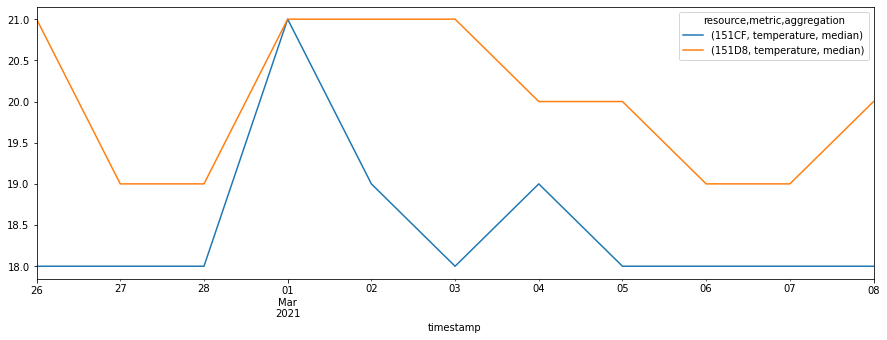

In [6]:
df_now.plot(figsize=(15,5))

You can override parameters of the query definition in a `params` argument.

In [7]:
df_2020_02 = waylay_client.analytics.query.data('151CF-temperature', params={
    'window': 'P100D','until':'2020-02-01'
})
df_2020_02.describe()

resource,151CF,151D8
metric,temperature,temperature
aggregation,median,median
count,100.000000,100.000000
mean,19.785000,19.385000
std,1.865767,1.946059
min,15.000000,16.000000
25%,17.750000,18.000000
50%,21.000000,20.000000
75%,21.000000,21.000000
max,22.000000,22.000000


<AxesSubplot:xlabel='timestamp'>

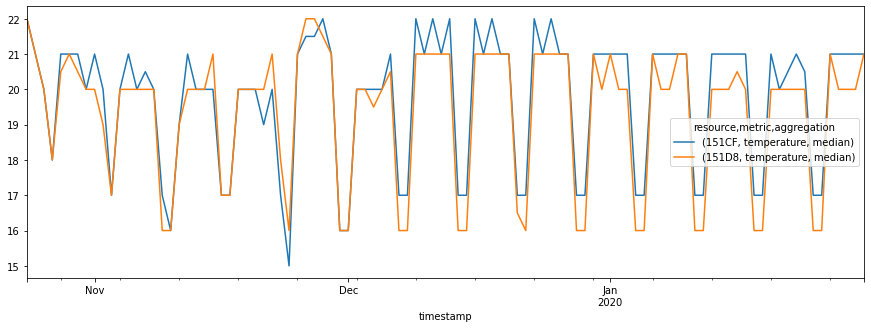

In [8]:
df_2020_02.plot(figsize=(15,5))

You can suppress the conversion to dataframes by setting `response_constructor=False`.

In [9]:
waylay_client.analytics.query.data(
    '151CF-temperature',
    params={'until':'2020-02-01', 'window':'P5D'},
    response_constructor=False
)

[{'columns': ['timestamp',
   {'resource': '151CF', 'metric': 'temperature', 'aggregation': 'median'},
   {'resource': '151D8', 'metric': 'temperature', 'aggregation': 'median'}],
  'data': [[1580083200000, 21, 21],
   [1580169600000, 21, 20],
   [1580256000000, 21, 20],
   [1580342400000, 21, 20],
   [1580428800000, 21, 21]],
  'data_axis': 'column',
  'attributes': {'role': 'input'},
  'window_spec': {'from': 1580083200000,
   'until': 1580515200000,
   'window': 'P5D',
   'freq': 'P1D'}}]

You can build your own query config definitions, store them `analytics.query.create`, and execute them.

In [10]:
new_query_cfg_name = '151CF-temperature-demo'
new_query_cfg = { 
    'name': new_query_cfg_name,
    'query': {},
    'meta': { 'description': 'demo, modified version of 151CF-temperature'}
}
new_query = dict(q_151CF_temp)
new_query_cfg['query'] = new_query
new_query['data'] = [ series for series in new_query['data'] if (series.get('metric') != 'lightAmbi') ]
new_query['until'] = '2020-02-01'
new_query['window'] = 'P30D'
new_query_cfg

{'name': '151CF-temperature-demo',
 'query': {'data': [{'metric': 'temperature',
    'resource': '151CF',
    'aggregation': 'median'},
   {'metric': 'temperature', 'resource': '151D8', 'aggregation': 'median'}],
  'freq': 'P1D',
  'window': 'P30D',
  'until': '2020-02-01'},
 'meta': {'description': 'demo, modified version of 151CF-temperature'}}

We first delete any existing query config under that name

In [11]:
### need to delete any existing query config first
from waylay import RestResponseError
try: 
    waylay_client.analytics.query.remove(new_query_cfg_name)
    print(f"'{new_query_cfg_name}' deleted")
except RestResponseError as exc:
    print(exc)

'151CF-temperature-demo' deleted


In [12]:
waylay_client.analytics.query.create(body=new_query_cfg)

{'data': [{'metric': 'temperature',
   'resource': '151CF',
   'aggregation': 'median'},
  {'metric': 'temperature', 'resource': '151D8', 'aggregation': 'median'}],
 'freq': 'P1D',
 'until': '2020-02-01',
 'window': 'P30D'}

<AxesSubplot:xlabel='timestamp'>

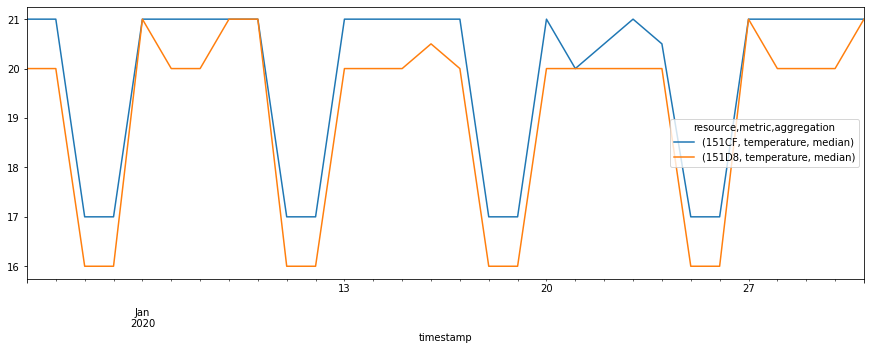

In [13]:
waylay_client.analytics.query.data(new_query_cfg_name).plot(figsize=(15,5))

a query config can be updated (the representation cannot have a name in it then)

<AxesSubplot:xlabel='timestamp'>

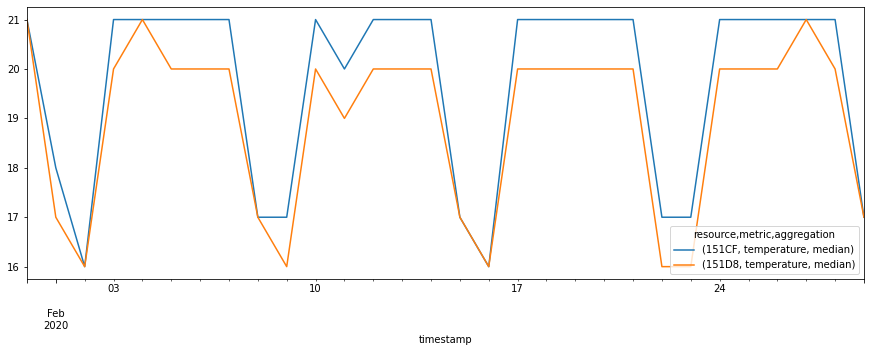

In [14]:
new_query['until'] = '2020-03-01'
waylay_client.analytics.query.replace('151CF-temperature-demo', body={'query': new_query})
waylay_client.analytics.query.data('151CF-temperature-demo').plot(figsize=(15,5))

If a query does not need to be stored, you can use  `analytics.query.execute` to execute a query without saving it as a Query Configuration

In [15]:
waylay_client.analytics.query.execute(body=new_query, params={'window':'P5D'})

resource,151CF,151D8
metric,temperature,temperature
aggregation,median,median
timestamp,,
2020-02-25 00:00:00+00:00,21,20
2020-02-26 00:00:00+00:00,21,20
2020-02-27 00:00:00+00:00,21,21
2020-02-28 00:00:00+00:00,21,20
2020-02-29 00:00:00+00:00,17,17
